## Analyzing Spatial Data with GeoPandas Using the Spatial Index (sindex)


In [21]:
import pandas as pd
import geopandas as gpd
from shapely import Point
import numpy as np
import geodatasets
import matplotlib.pyplot as plt

In [40]:
# Read some example geodata with different geometry types

# Point data
df_cars = pd.read_csv(geodatasets.get_path("geoda.cars"))
geometry = gpd.points_from_xy(df_cars.Longitude, df_cars.Latitude)
gdf_cars = gpd.GeoDataFrame(df_cars, geometry=geometry, crs="EPSG:4326")

# MultiPolygon data
gdf_communities = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop"), crs="EPSG:4326")

### Finding the Nearest Object
The `nearest` method can be used with single or multiple geometries. Accepted formats include `shapely.geometry`, `GeoSeries`, `GeometryArray`, and `numpy.array of Shapely geometries`.

In this example, we want to find the nearest abandoned vehicle to specific public places in Chicago using the `nearest` method. We start by specifying two locations in Chicago using shapely.geometry.Point objects. The points are stored in a numpy.array.

We then use the nearest method of the spatial index (sindex) to identify the closest abandoned vehicles to these locations from the 'Abandoned Cars in Chicago' dataset. The nearest method returns two sets of indices: indices_location (for the input locations) and indices_vehicles (for the nearest vehicles).

Finally, we loop through each location and its corresponding nearest vehicle. For each pair, we extract the vehicle color and make/model, and print a message with the results.

In [27]:
chicago_lincoln_square = Point(-87.68897964828476, 41.96859458449132)
chicago_montrose_beach = Point(-87.6395219482705, 41.96768758127601)
locations = np.array([chicago_lincoln_square, chicago_airport])

indices = gdf_cars.sindex.nearest(locations)

indices_location = indices[0]
indices_vehicles  = indices[1]

for index_location, index_vehicle in zip(indices_location, indices_vehicles):
    location_x = locations[index_location].x
    location_y = locations[index_location].y
    car_color = gdf_cars.loc[index_vehicle, 'Vehicle Color']
    car_model = gdf_cars.loc[index_vehicle, 'Vehicle Make/Model']
    print(f"The closest abandoned car to this location {location_x, location_y} was a {car_color.lower()} {car_model}")

The closest abandoned car to this location (-87.68897964828476, 41.96859458449132) was a gray Jeep - Year Greater 1988
The closest abandoned car to this location (-87.6395219482705, 41.96768758127601) was a black Toyota


### Efficient querying with spatial index

In the following example, the goal is to identify all abandoned vehicles within specific Chicago communities. We'll start by filtering the Chicago community population dataset (commpop) to get the communities of interest. Then, we will use the `query` method with the appropriate spatial predicate to efficiently identify the abandoned vehicles in these areas.

#### Note: Spatial query predicates
Spatial query predicates are operations used to evaluate the spatial relationships between shapes, such as determining if one shape contains, intersects, or is crosses another. You can print a set of valid predicates for this spatial index with the `valid_query_predicates` property

In [32]:
gdf_communities.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'intersects',
 'overlaps',
 'touches',
 'within'}

In [51]:
communities_of_interest = ['DOUGLAS', 'OAKLAND', 'FULLER PARK']
gdf_community_subset = gdf_communities[gdf_communities['community'].isin(communities_of_interest)].reset_index()

indices_community, indices_car = gdf_cars.sindex.query(geometry=gdf_community_subset.geometry, predicate='intersects')

gdf_cars_filtered = gdf_cars.iloc[indices_car].reset_index(drop=True)
gdf_community_filtered = gdf_community_subset.iloc[indices_community].reset_index(drop=True)

gdf_cars_filtered['community'] = gdf_community_filtered['community']

car_counts_per_community = gdf_cars_filtered.groupby('community').size().reset_index(name='car_count')
print(car_counts_per_community)

     community  car_count
0      DOUGLAS        490
1  FULLER PARK        176
2      OAKLAND        273


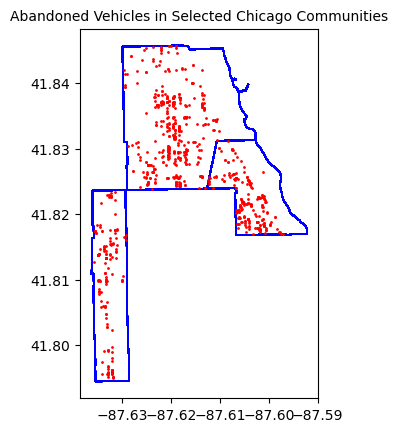

In [58]:
fig, ax = plt.subplots()
ax.set_title("Abandoned Vehicles in Selected Chicago Communities", fontsize=10)
gdf_community_filtered.plot(ax=ax, edgecolor="blue", facecolor="none")
gdf_cars_filtered.plot(ax=ax, color="red", markersize=1)
plt.show()